In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
import pickle
import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
import tensorflow as tf
from keras.layers import concatenate, Dense, Input, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequentialو Model
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy, cosine_similarity
from keras.metrics import categorical_accuracy, categorical_crossentropy
from keras.backend import expand_dims
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import  GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
df = pd.read_csv('Multimodal Dataset for Gas Detection and Classification/Gas Sensors Measurements/Gas_Sensors_Measurements.csv')

In [ ]:
df.head()

,Serial Number,MQ2,MQ3,MQ5,MQ6,MQ7,MQ8,MQ135,Gas,Corresponding Image Name
0,0,555,515,377,338,666,451,416,NoGas,0_NoGas
1,1,555,516,377,339,666,451,416,NoGas,1_NoGas
2,2,556,517,376,337,666,451,416,NoGas,2_NoGas
3,3,556,516,376,336,665,451,416,NoGas,3_NoGas
4,4,556,516,376,337,665,451,416,NoGas,4_NoGas


## EDA

In [ ]:
df['Gas'].unique()

array(['NoGas', 'Perfume', 'Smoke', 'Mixture'], dtype=object)

In [ ]:
cat_features = ['Gas']
num_features = df.columns[1:-2]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Serial Number             6400 non-null   int64 
 1   MQ2                       6400 non-null   int64 
 2   MQ3                       6400 non-null   int64 
 3   MQ5                       6400 non-null   int64 
 4   MQ6                       6400 non-null   int64 
 5   MQ7                       6400 non-null   int64 
 6   MQ8                       6400 non-null   int64 
 7   MQ135                     6400 non-null   int64 
 8   Gas                       6400 non-null   object
 9   Corresponding Image Name  6400 non-null   object
dtypes: int64(8), object(2)
memory usage: 500.1+ KB


In [ ]:
df.describe(include=['object', 'int64']).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Serial Number,6400.0,NaN,NaN,NaN,799.5,461.916214,0.0,399.75,799.5,1199.25,1599.0
MQ2,6400.0,NaN,NaN,NaN,677.593438,92.913955,502.0,591.0,701.0,756.0,824.0
MQ3,6400.0,NaN,NaN,NaN,462.024688,70.284038,337.0,405.0,486.0,529.0,543.0
MQ5,6400.0,NaN,NaN,NaN,404.579063,55.672249,291.0,366.0,400.0,443.0,596.0
MQ6,6400.0,NaN,NaN,NaN,399.75875,45.091353,311.0,366.0,393.0,426.0,524.0
MQ7,6400.0,NaN,NaN,NaN,565.952031,83.133693,361.0,524.0,576.0,629.0,796.0
MQ8,6400.0,NaN,NaN,NaN,542.47375,151.020217,220.0,447.0,576.0,642.0,794.0
MQ135,6400.0,NaN,NaN,NaN,416.727031,76.681407,275.0,354.0,437.0,473.0,589.0
Gas,6400,4,NoGas,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Corresponding Image Name,6400,6400,0_NoGas,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


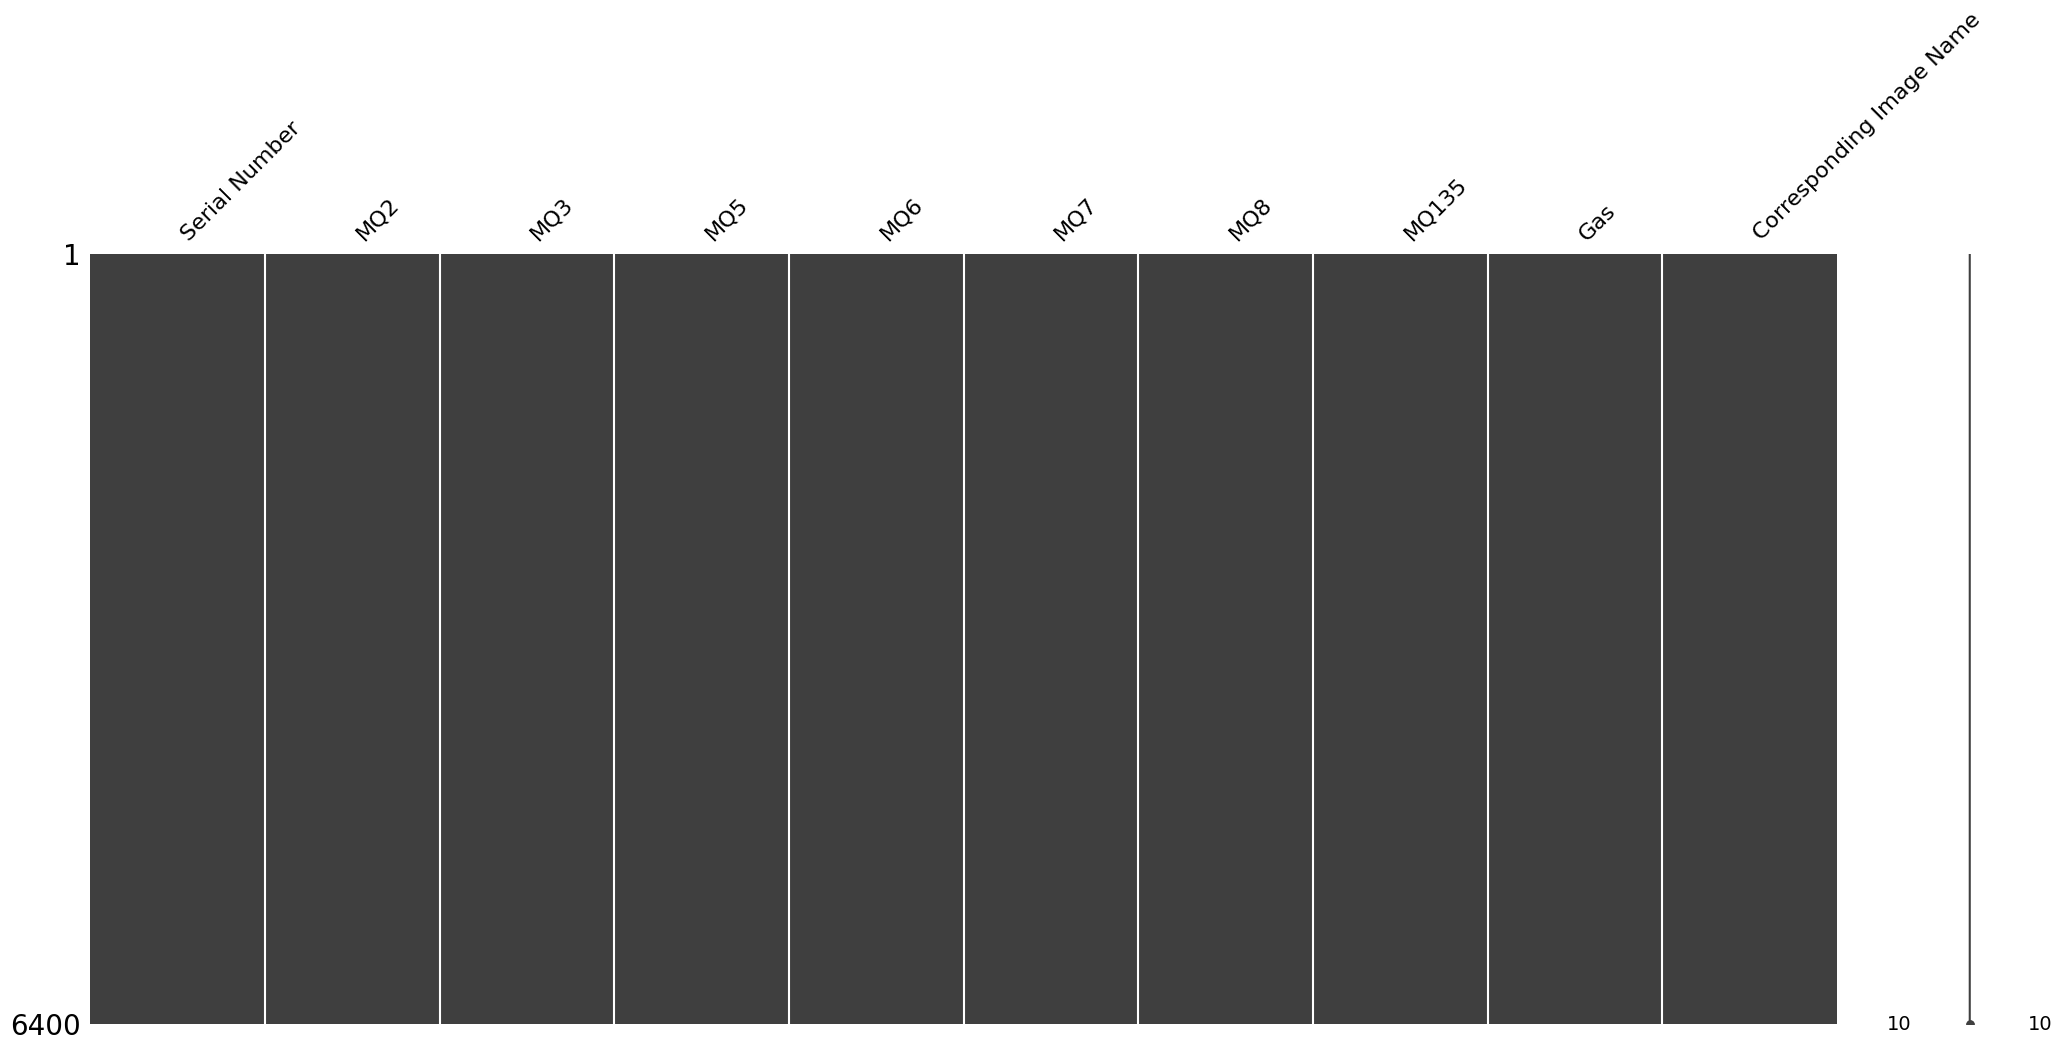

In [ ]:
import missingno as msno
msno.matrix(df);

<Axes: xlabel='Gas', ylabel='count'>

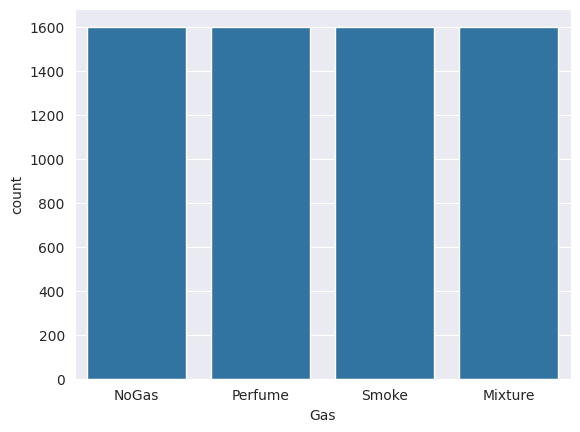

In [ ]:
sns.countplot(data=df, x='Gas' )

<Axes: xlabel='MQ135', ylabel='Density'>

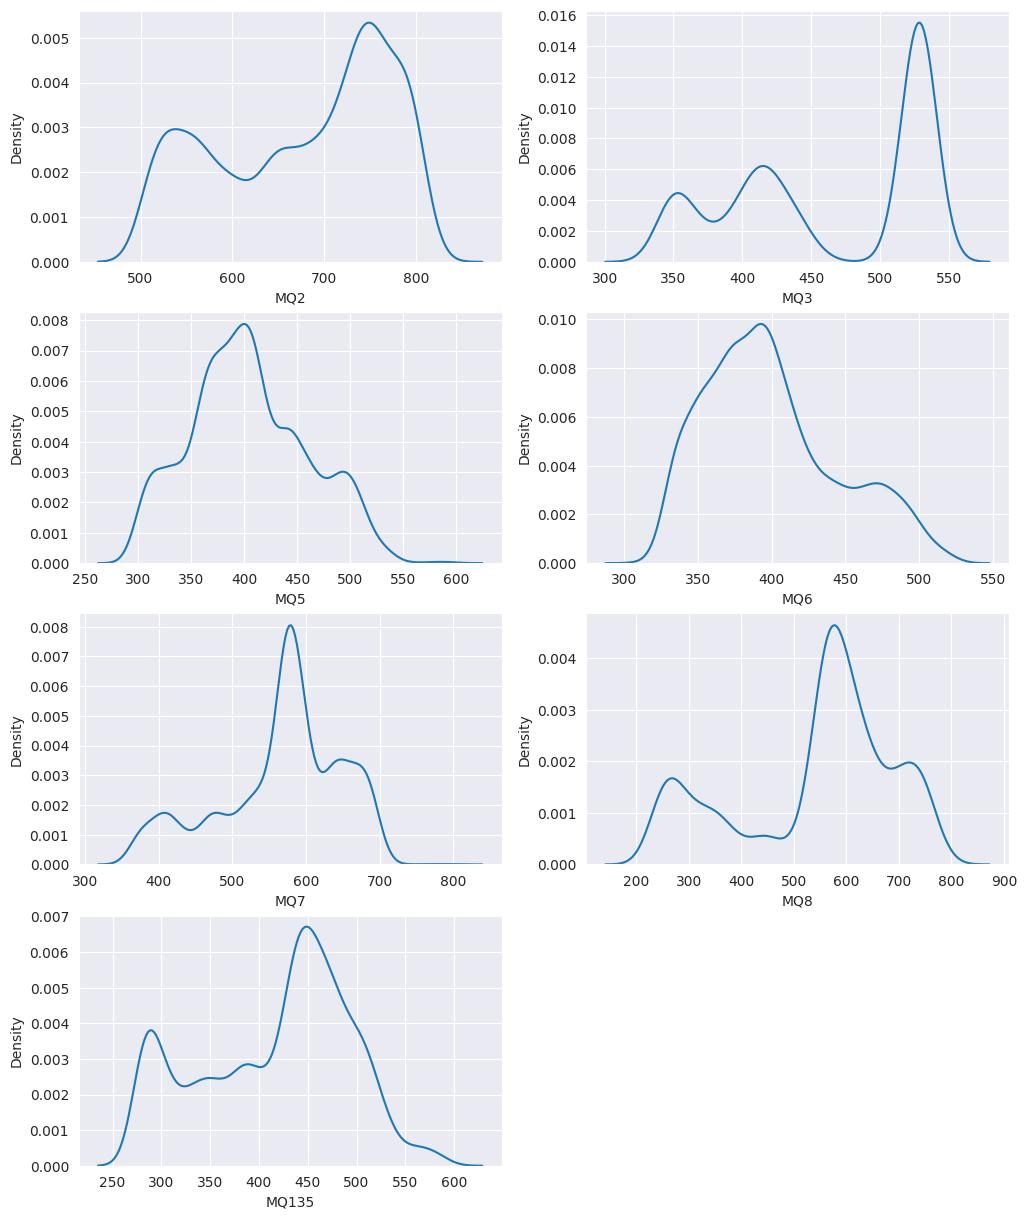

In [ ]:
plt.figure(figsize=(12,15))

plt.subplot(4,2,1)
sns.kdeplot(data=df, x='MQ2')

plt.subplot(4,2,2)
sns.kdeplot(data=df, x='MQ3')

plt.subplot(4,2,3)
sns.kdeplot(data=df, x='MQ5')

plt.subplot(4,2,4)
sns.kdeplot(data=df, x='MQ6')

plt.subplot(4,2,5)
sns.kdeplot(data=df, x='MQ7')

plt.subplot(4,2,6)
sns.kdeplot(data=df, x='MQ8')

plt.subplot(4,2,7)
sns.kdeplot(data=df, x='MQ135')

<AxesSubplot:xlabel='MQ135', ylabel='Density'>

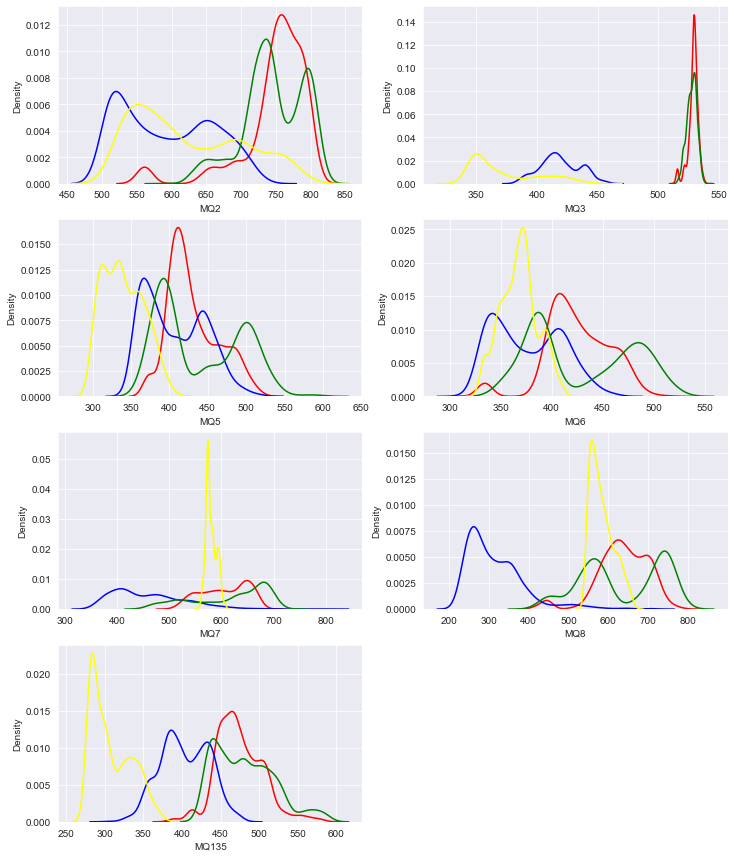

In [ ]:
plt.figure(figsize=(12,15))

plt.subplot(4,2,1)
sns.kdeplot(data=df[df['Gas'] == 'NoGas'], x='MQ2', color = 'red')
sns.kdeplot(data=df[df['Gas'] == 'Mixture'], x='MQ2', color = 'blue')
sns.kdeplot(data=df[df['Gas'] == 'Perfume'], x='MQ2', color = 'green')
sns.kdeplot(data=df[df['Gas'] == 'Smoke'], x='MQ2', color = 'yellow')


plt.subplot(4,2,2)
sns.kdeplot(data=df[df['Gas'] == 'NoGas'], x='MQ3', color = 'red')
sns.kdeplot(data=df[df['Gas'] == 'Mixture'], x='MQ3', color = 'blue')
sns.kdeplot(data=df[df['Gas'] == 'Perfume'], x='MQ3', color = 'green')
sns.kdeplot(data=df[df['Gas'] == 'Smoke'], x='MQ3', color = 'yellow')


plt.subplot(4,2,3)
sns.kdeplot(data=df[df['Gas'] == 'NoGas'], x='MQ5', color = 'red')
sns.kdeplot(data=df[df['Gas'] == 'Mixture'], x='MQ5', color = 'blue')
sns.kdeplot(data=df[df['Gas'] == 'Perfume'], x='MQ5', color = 'green')
sns.kdeplot(data=df[df['Gas'] == 'Smoke'], x='MQ5', color = 'yellow')


plt.subplot(4,2,4)
sns.kdeplot(data=df[df['Gas'] == 'NoGas'], x='MQ6', color = 'red')
sns.kdeplot(data=df[df['Gas'] == 'Mixture'], x='MQ6', color = 'blue')
sns.kdeplot(data=df[df['Gas'] == 'Perfume'], x='MQ6', color = 'green')
sns.kdeplot(data=df[df['Gas'] == 'Smoke'], x='MQ6', color = 'yellow')


plt.subplot(4,2,5)
sns.kdeplot(data=df[df['Gas'] == 'NoGas'], x='MQ7', color = 'red')
sns.kdeplot(data=df[df['Gas'] == 'Mixture'], x='MQ7', color = 'blue')
sns.kdeplot(data=df[df['Gas'] == 'Perfume'], x='MQ7', color = 'green')
sns.kdeplot(data=df[df['Gas'] == 'Smoke'], x='MQ7', color = 'yellow')


plt.subplot(4,2,6)
sns.kdeplot(data=df[df['Gas'] == 'NoGas'], x='MQ8', color = 'red')
sns.kdeplot(data=df[df['Gas'] == 'Mixture'], x='MQ8', color = 'blue')
sns.kdeplot(data=df[df['Gas'] == 'Perfume'], x='MQ8', color = 'green')
sns.kdeplot(data=df[df['Gas'] == 'Smoke'], x='MQ8', color = 'yellow')


plt.subplot(4,2,7)
sns.kdeplot(data=df[df['Gas'] == 'NoGas'], x='MQ135', color = 'red')
sns.kdeplot(data=df[df['Gas'] == 'Mixture'], x='MQ135', color = 'blue')
sns.kdeplot(data=df[df['Gas'] == 'Perfume'], x='MQ135', color = 'green')
sns.kdeplot(data=df[df['Gas'] == 'Smoke'], x='MQ135', color = 'yellow')

<Axes: ylabel='MQ135'>

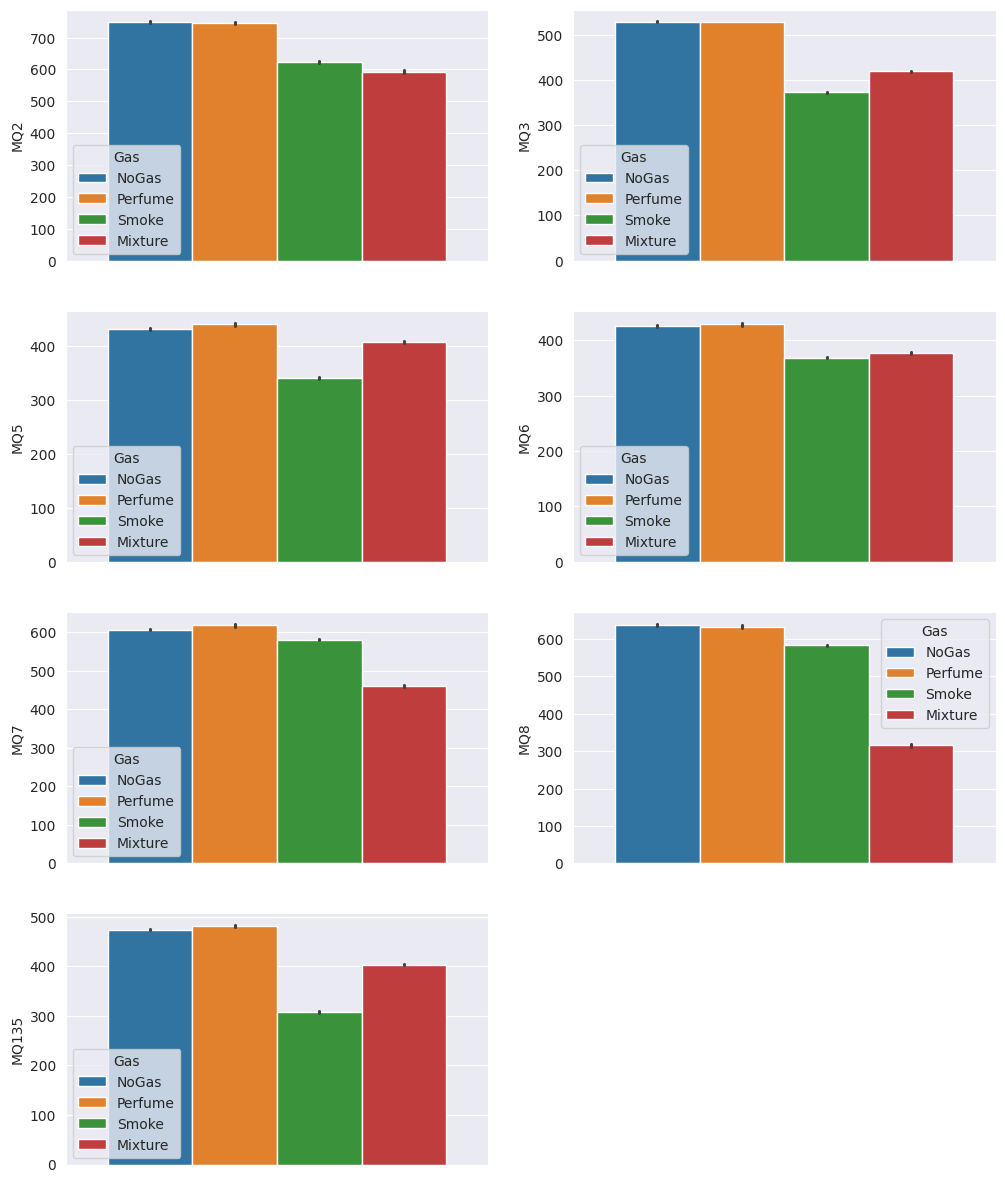

In [ ]:
plt.figure(figsize=(12,15))
plt.subplot(4,2,1)
sns.barplot(data=df, y='MQ2', hue='Gas',orient='y')

plt.subplot(4,2,2)
sns.barplot(data=df, y='MQ3', hue='Gas',orient='y')

plt.subplot(4,2,3)
sns.barplot(data=df, y='MQ5', hue='Gas',orient='y')

plt.subplot(4,2,4)
sns.barplot(data=df, y='MQ6', hue='Gas',orient='y')

plt.subplot(4,2,5)
sns.barplot(data=df, y='MQ7', hue='Gas',orient='y')

plt.subplot(4,2,6)
sns.barplot(data=df, y='MQ8', hue='Gas',orient='y')

plt.subplot(4,2,7)
sns.barplot(data=df, y='MQ135', hue='Gas',orient='y')

<Axes: xlabel='MQ3', ylabel='MQ6'>

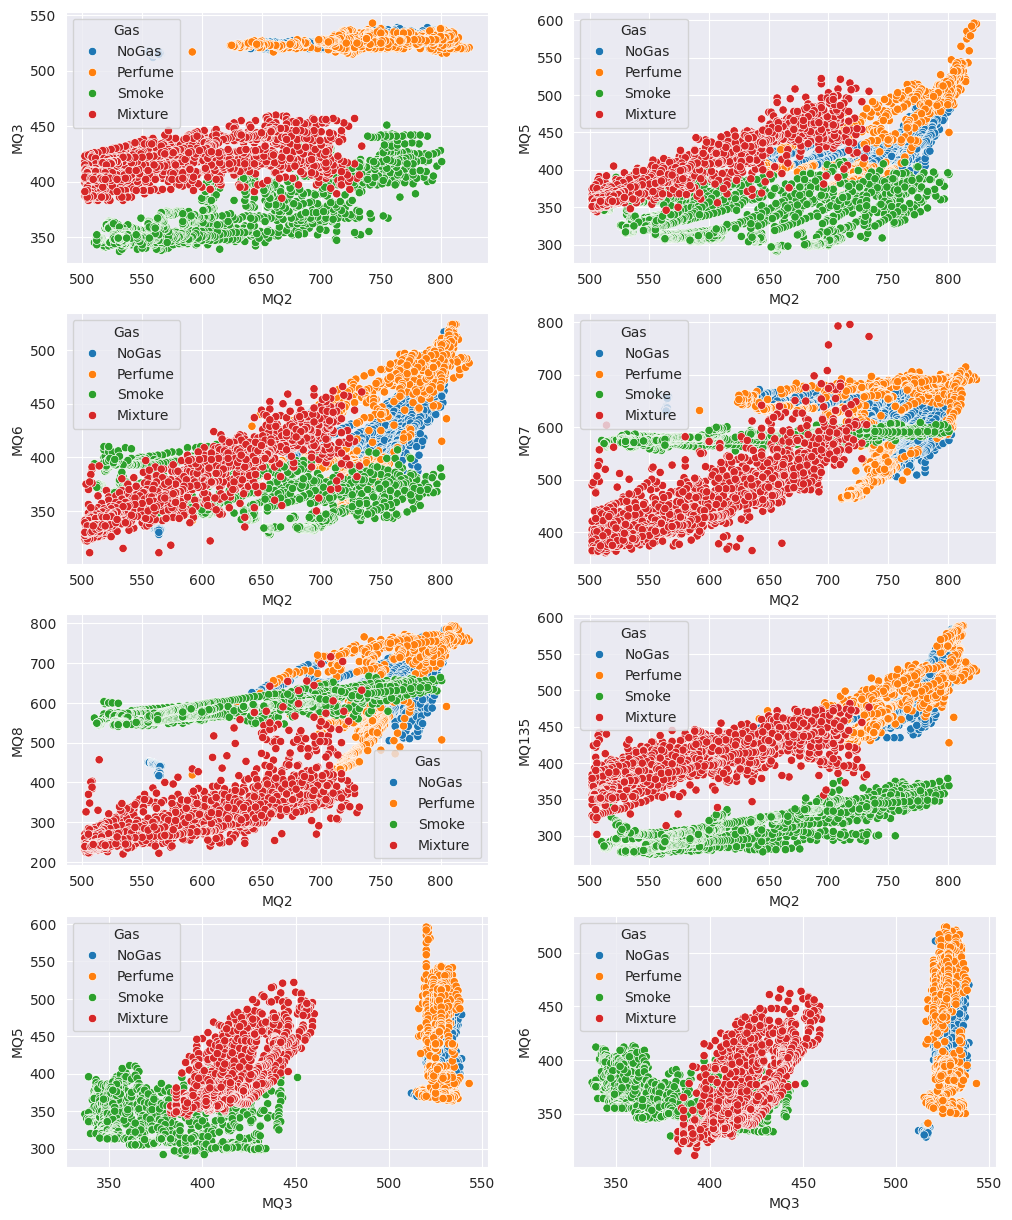

In [ ]:
plt.figure(figsize=(12,15))

plt.subplot(4,2,1)
sns.scatterplot(data=df, x= 'MQ2', y='MQ3', hue='Gas')

plt.subplot(4,2,2)
sns.scatterplot(data=df, x= 'MQ2', y='MQ5', hue='Gas')

plt.subplot(4,2,3)
sns.scatterplot(data=df, x= 'MQ2', y='MQ6', hue='Gas')

plt.subplot(4,2,4)
sns.scatterplot(data=df, x= 'MQ2', y='MQ7', hue='Gas')

plt.subplot(4,2,5)
sns.scatterplot(data=df, x= 'MQ2', y='MQ8', hue='Gas')

plt.subplot(4,2,6)
sns.scatterplot(data=df, x= 'MQ2', y='MQ135', hue='Gas')

plt.subplot(4,2,7)
sns.scatterplot(data=df, x= 'MQ3', y='MQ5', hue='Gas')

plt.subplot(4,2,8)
sns.scatterplot(data=df, x= 'MQ3', y='MQ6', hue='Gas')



<AxesSubplot:xlabel='MQ2', ylabel='MQ135'>

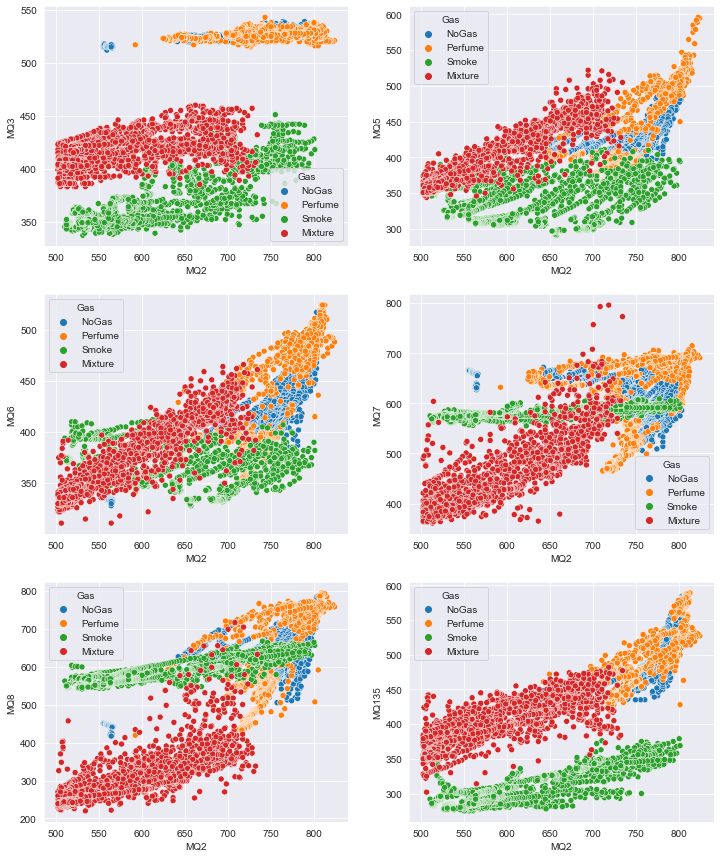

In [ ]:
plt.figure(figsize=(12,15))

plt.subplot(3,2,1)
sns.scatterplot(data=df, x= 'MQ2', y='MQ3', hue='Gas')

plt.subplot(3,2,2)
sns.scatterplot(data=df, x= 'MQ2', y='MQ5', hue='Gas')

plt.subplot(3,2,3)
sns.scatterplot(data=df, x= 'MQ2', y='MQ6', hue='Gas')

plt.subplot(3,2,4)
sns.scatterplot(data=df, x= 'MQ2', y='MQ7', hue='Gas')

plt.subplot(3,2,5)
sns.scatterplot(data=df, x= 'MQ2', y='MQ8', hue='Gas')

plt.subplot(3,2,6)
sns.scatterplot(data=df, x= 'MQ2', y='MQ135', hue='Gas')




<AxesSubplot:xlabel='MQ7', ylabel='MQ8'>

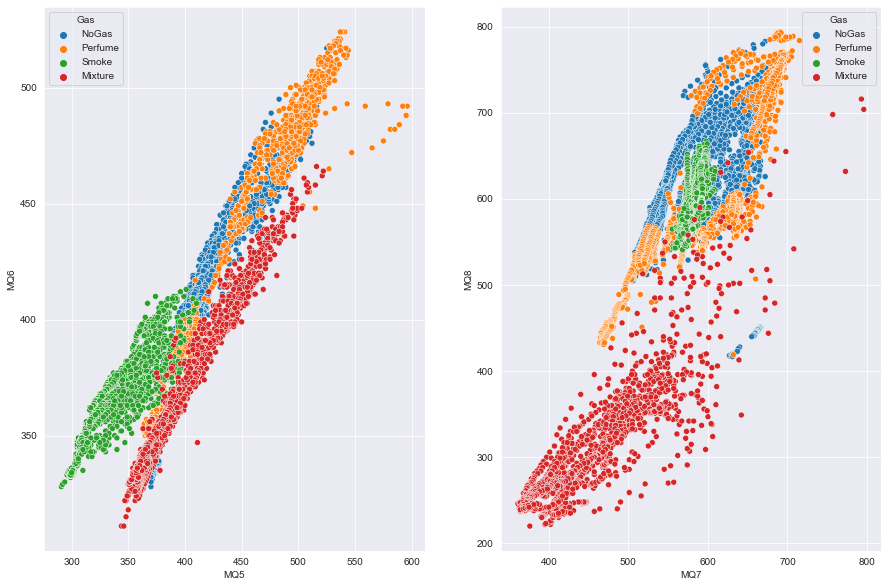

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
sns.scatterplot(data=df, x= 'MQ5', y='MQ6', hue='Gas')

plt.subplot(1,2,2)
sns.scatterplot(data=df, x= 'MQ7', y='MQ8', hue='Gas')

<Axes: >

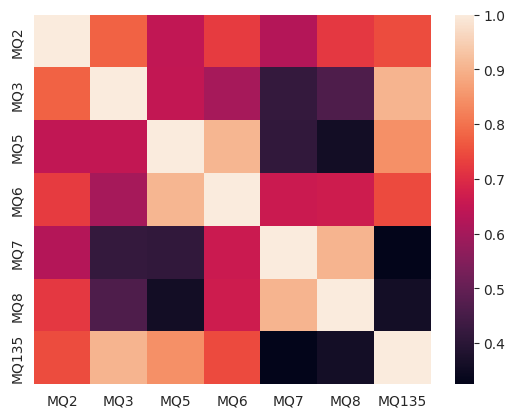

In [ ]:
sns.heatmap(df[num_features].corr())

## Pre Process

In [ ]:
cat_features = ['Gas']
num_features = df.columns[1:-2]

In [ ]:
df['Gas'] = LabelEncoder().fit_transform(df['Gas'])

In [ ]:
X = df[num_features]
Y = df['Gas']

In [ ]:
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X)

In [ ]:
# import numpy as np
# class_0, class_1, class_2 = np.split(df.sample(frac=1, random_state=42),
#                                     [int(.05*len(df)), int(.20*len(df))])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [ ]:
image_names_train, image_names_test = train_test_split(df['Corresponding Image Name'], random_state=42)

(array([1221.,    0.,    0., 1166.,    0.,    0., 1207.,    0.,    0.,
        1206.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

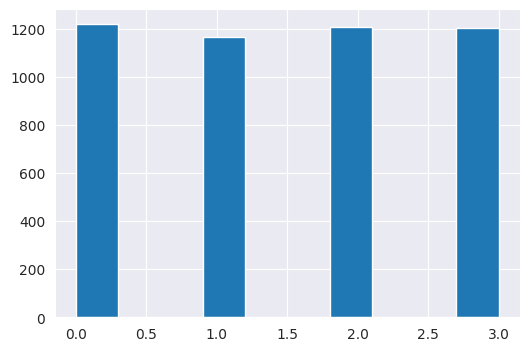

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(y_train)

(array([379.,   0.,   0., 434.,   0.,   0., 393.,   0.,   0., 394.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

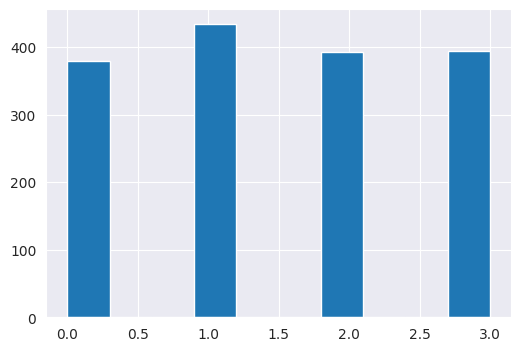

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(y_test)

In [ ]:
splitted_images_dir = 'Multimodal Dataset for Gas Detection and Classification/Thermal Camera Images Splitted'
labels = ['Mixture', 'NoGas', 'Perfume', 'Smoke']

In [ ]:

os.mkdir(splitted_images_dir)
os.mkdir(f'{splitted_images_dir}/train')
os.mkdir(f'{splitted_images_dir}/test')

[os.mkdir(f'{splitted_images_dir}/train/{label}') for label in labels]
[os.mkdir(f'{splitted_images_dir}/test/{label}') for label in labels]

[None, None, None, None]

In [ ]:
images_dir = 'Multimodal Dataset for Gas Detection and Classification/Thermal Camera Images'
for label in os.listdir(images_dir):
    for image in os.listdir(f'{images_dir}/{label}'):
        if image.split('.')[0] in list(image_names_train):
            shutil.copy(f'{images_dir}/{label}/{image}', f'{splitted_images_dir}/train/{label}/{image}')
        else:
            shutil.copy(f'{images_dir}/{label}/{image}', f'{splitted_images_dir}/test/{label}/{image}')

## Numerical Model

### Frequentist Models

In [ ]:
random_forest = RandomForestClassifier()
random_forest = random_forest.fit(x_train, y_train)
y_pred_rf = random_forest.predict(x_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
pre_rf = precision_score(y_test, y_pred_rf, average='weighted')
rec_rf = recall_score(y_test, y_pred_rf, average='weighted')
confusion_rf = confusion_matrix(y_test, y_pred_rf)
accuracy_rf, pre_rf, rec_rf ,f1_rf, confusion_rf

(0.976875,
 0.9769233368181233,
 0.976875,
 0.9768810977128267,
 array([[379,   0,   0,   0],
        [  0, 413,  21,   0],
        [  0,  16, 377,   0],
        [  0,   0,   0, 394]]))

In [ ]:
knn = KNeighborsClassifier()
knn = knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
pre_knn = precision_score(y_test, y_pred_knn, average='weighted')
rec_knn = recall_score(y_test, y_pred_knn, average='weighted')
confusion_knn = confusion_matrix(y_test, y_pred_knn)
accuracy_knn, pre_knn,rec_knn, f1_knn, confusion_knn

(0.97,
 0.9702356503422854,
 0.97,
 0.9700152835359427,
 array([[379,   0,   0,   0],
        [  0, 404,  30,   0],
        [  0,  18, 375,   0],
        [  0,   0,   0, 394]]))

In [ ]:
svc = SVC()
svc = svc.fit(x_train, y_train)
y_pred_svc = svc.predict(x_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')
confusion_svc = confusion_matrix(y_test, y_pred_svc)
accuracy_svc, f1_svc, confusion_svc

(0.925,
 0.9250043864266414,
 array([[379,   0,   0,   0],
        [  0, 354,  80,   0],
        [  0,  40, 353,   0],
        [  0,   0,   0, 394]]))

### Probabilitistic Model

In [ ]:
nb = GaussianNB()
nb = nb.fit(x_train, y_train)
y_pred_nb = nb.predict(x_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')
confusion_nb = confusion_matrix(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='weighted')
recal_nb = recall_score(y_test, y_pred_nb, average='weighted')
accuracy_nb, f1_nb,precision_nb,recal_nb, confusion_nb


(0.8525,
 0.8507119613802969,
 0.8547003250711093,
 0.8525,
 array([[379,   0,   0,   0],
        [  0, 352,  82,   0],
        [  0, 154, 239,   0],
        [  0,   0,   0, 394]]))

### Neural Network

In [ ]:
y_train_cat = to_categorical(y_train, num_classes=4)


model_num = Sequential()

model_num.add(Dense(64, activation='relu', input_shape=(7,)))
model_num.add(Dense(32, activation='relu'))
model_num.add(Dense(4, activation='softmax'))

model_num.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_num.fit(x_train.values, y_train_cat, epochs=80, batch_size=10)
# _, accuracy = model_num.evaluate(x_test, y_test)

Epoch 1/80
480/480 [==============================] - 3s 3ms/step - loss: 6.0060 - accuracy: 0.6733
Epoch 2/80
480/480 [==============================] - 1s 3ms/step - loss: 0.9878 - accuracy: 0.7627
Epoch 3/80
480/480 [==============================] - 2s 3ms/step - loss: 0.9996 - accuracy: 0.7954
Epoch 4/80
480/480 [==============================] - 2s 4ms/step - loss: 0.7186 - accuracy: 0.8096
Epoch 5/80
480/480 [==============================] - 1s 2ms/step - loss: 0.9783 - accuracy: 0.8085
Epoch 6/80
480/480 [==============================] - 1s 2ms/step - loss: 0.6138 - accuracy: 0.8281
Epoch 7/80
480/480 [==============================] - 1s 2ms/step - loss: 0.4490 - accuracy: 0.8462
Epoch 8/80
480/480 [==============================] - 1s 2ms/step - loss: 0.5910 - accuracy: 0.8244
Epoch 9/80
480/480 [==============================] - 1s 2ms/step - loss: 0.4391 - accuracy: 0.8460
Epoch 10/80
480/480 [==============================] - 1s 2ms/step - loss: 0.5070 - accuracy: 0.8360

In [ ]:
model_num = Sequential()

model_num.add(Dense(64, activation='relu', input_shape=(7,)))
model_num.add(Dense(32, activation='relu'))
model_num.add(Dense(4, activation='softmax'))
model_num = Model(inputs=model_num.input, outputs=model_num.output)

## Image Model

In [ ]:
image_size = (128,128)
batch_size = 30

train_data_dir = f'{splitted_images_dir}/train'
test_data_dir = f'{splitted_images_dir}/test'

train_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

train_dataset = train_data_generator.flow_from_directory(
    train_data_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical'
)

test_dataset = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(128, 128),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4800 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.


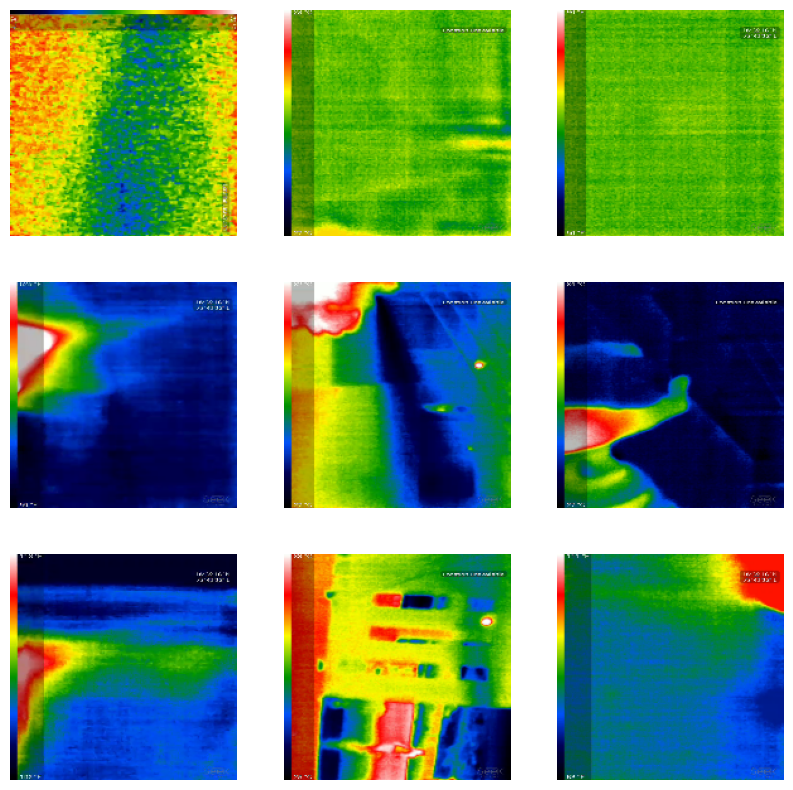

In [ ]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(np.array(images[i]).astype("uint8"))
#         # plt.title(int(labels[i]))
#         plt.axis("off")

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

image_size = (128,128)
model = make_model(input_shape=image_size + (3,), num_classes=4)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
)
model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_dataset,
)

Epoch 1/25
160/160 [==============================] - 747s 5s/step - loss: 0.2654 - acc: 0.8772 - val_loss: 0.6440 - val_acc: 0.7500
Epoch 2/25
160/160 [==============================] - 810s 5s/step - loss: 0.1292 - acc: 0.9479 - val_loss: 0.6323 - val_acc: 0.7500
Epoch 3/25
160/160 [==============================] - 704s 4s/step - loss: 0.0879 - acc: 0.9663 - val_loss: 0.7869 - val_acc: 0.7500
Epoch 4/25
160/160 [==============================] - 686s 4s/step - loss: 0.0714 - acc: 0.9725 - val_loss: 0.7638 - val_acc: 0.7500
Epoch 5/25
160/160 [==============================] - 686s 4s/step - loss: 0.0489 - acc: 0.9821 - val_loss: 0.7809 - val_acc: 0.6678
Epoch 6/25
160/160 [==============================] - 699s 4s/step - loss: 0.0433 - acc: 0.9826 - val_loss: 1.7864 - val_acc: 0.6356
Epoch 7/25
160/160 [==============================] - 674s 4s/step - loss: 0.0328 - acc: 0.9880 - val_loss: 1.6788 - val_acc: 0.6363
Epoch 8/25
160/160 [==============================] - 556s 3s/step - 

In [ ]:
model.save_weights('keras_model_weights.h5')

In [ ]:
pickle.dump(model, open('keras_model.pkl', 'wb'))

1/1 [==============================] - 0s 278ms/step
0.0


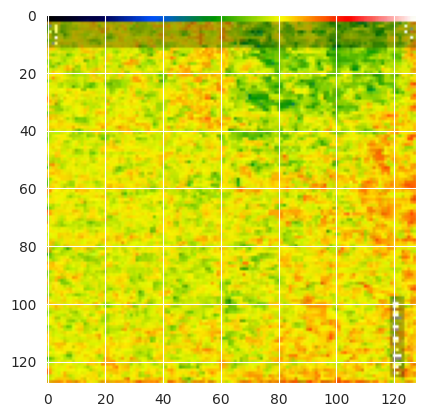

In [ ]:
img = keras.utils.load_img(f"{splitted_images_dir}/test/Mixture/10_Mixture.png", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.keras.backend.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.backend.sigmoid(predictions[0][0]))
print(score)

In [ ]:
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
model.load_weights('keras_model_weights.h5')

In [ ]:
y_pred_nn = model.predict(test_dataset)

54/54 [==============================] - 53s 965ms/step


In [ ]:
y_classes_nn = y_pred_nn.argmax(axis=-1)

In [ ]:
model = Model(inputs=model.input, outputs=model.output)

In [ ]:
model.input

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'input_3')>

## Ensemble

In [ ]:
train_datast_tensor = [keras.backend.constant(train_dataset[i][0][0][0]) for i in range(len(train_dataset))]

In [ ]:
# train_tensor = Input(train_datast_tensor)
# train_tensor = tf.data.Dataset.from_tensor_slices(train_datast_tensor)
# train_datast_tensor = [tf.convert_to_tensor(i) for i in train_datast_tensor]
# train_tensor = tf.convert_to_tensor(train_datast_tensor)
train_tensor = tf.keras.preprocessing.sequence.pad_sequences(train_datast_tensor, padding='post')


In [ ]:
dataset_image = tf.data.Dataset.from_generator(
    lambda: train_dataset,
    output_signature=tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32)
)

In [ ]:
dataset_x = tf.data.Dataset.from_tensor_slices(x_train.values)
dataset_y = tf.data.Dataset.from_tensor_slices(y_train.values)

In [ ]:
combined = concatenate([model.output, model_num.output])

z = Dense(512,activation="relu",kernel_initializer = "he_uniform")(expand_dims(combined , 0))
z = Dense(512, activation = "relu",kernel_initializer = "he_uniform")(z)
z = Dense(224,activation="softmax")(z)

multimodal_model = Model(inputs=[train_tensor, x_train.values], outputs=z)

multimodal_model.compile(optimizer='rmsprop',
              loss=[categorical_crossentropy, cosine_similarity],
              metrics=[categorical_accuracy, categorical_crossentropy])

In [ ]:
multimodal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

multimodal_model.fit(tf.data.Dataset.concatenate(dataset_x, dataset_image), dataset_y, epochs=10, batch_size=32)

## WideDeep

In [ ]:
import numpy as np
import pandas as pd
import os
import torch

from pytorch_widedeep import Trainer
from pytorch_widedeep.preprocessing import (
    WidePreprocessor,
    TabPreprocessor,
    TextPreprocessor,
    ImagePreprocessor,
)
from pytorch_widedeep.models import (
    Wide,
    TabMlp,
    Vision,
    BasicRNN,
    WideDeep,
)
from pytorch_widedeep.metrics import Accuracy, Precision, F1Score

from pytorch_widedeep.losses import RMSELoss
from pytorch_widedeep.initializers import *
from pytorch_widedeep.callbacks import *
from captum.attr._core.feature_permutation import FeaturePermutation


/home/romina/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
image_unlabeled_dir = 'Multimodal Dataset for Gas Detection and Classification/Thermal Camera Images Unlabeled'

In [ ]:
os.mkdir(image_unlabeled_dir)
images_dir = 'Multimodal Dataset for Gas Detection and Classification/Thermal Camera Images'
for label in os.listdir(images_dir):
    for image in os.listdir(f'{images_dir}/{label}'):
        shutil.copy(f'{images_dir}/{label}/{image}', image_unlabeled_dir)

In [ ]:
df['image_name'] = df['Corresponding Image Name']+'.png'

In [ ]:
continuous_cols = num_features

img_col = 'image_name'
img_path = image_unlabeled_dir

target_col = 'Gas'

In [ ]:
target = df[target_col].values

In [ ]:
tab_preprocessor = TabPreprocessor(
    continuous_cols=continuous_cols
)
X_tab = tab_preprocessor.fit_transform(df)

/home/romina/.local/lib/python3.8/site-packages/pytorch_widedeep/preprocessing/tab_preprocessor.py:343: UserWarning: Continuous columns will not be normalised
  warnings.warn("Continuous columns will not be normalised")


In [ ]:
image_processor = ImagePreprocessor(img_col=img_col, img_path=img_path)
X_images = image_processor.fit_transform(df)

Reading Images from Multimodal Dataset for Gas Detection and Classification/Thermal Camera Images Unlabeled
Resizing


100%|██████████| 6400/6400 [00:14<00:00, 449.74it/s]


Computing normalisation metrics


In [ ]:

tab_mlp = TabMlp(
    column_idx=tab_preprocessor.column_idx,
    # cat_embed_input=tab_preprocessor.cat_embed_input,
    # cat_embed_dropout=0.1,
    continuous_cols=continuous_cols,
    mlp_hidden_dims=[128, 64],
    mlp_dropout=0.1,
)

resnet = Vision(pretrained_model_setup="resnet18", n_trainable=4)

In [ ]:
model = WideDeep(
    # wide=wide,
    deeptabular=tab_mlp,
    deepimage=resnet,
    head_hidden_dims=[256, 128],
    pred_dim=4
)

In [ ]:
trainer = Trainer(model, objective="categorical_cross_entropy",
                  optimizers=torch.optim.AdamW(model.parameters(), lr=0.01),
                  metrics=[Accuracy, Precision, F1Score])

In [ ]:
trainer.fit(
    X_tab=X_tab,
    X_img=X_images,
    target=target,
    n_epochs=5,
    batch_size=32,
    val_split=0.2,
)

valid: 100%|██████████| 40/40 [00:44<00:00,  1.11s/it, loss=0.138, metrics={'acc': 0.95, 'prec': 0.9508, 'f1': 0.95}]    


In [ ]:
deep_params = []
for childname, child in model.named_children():
    if childname == "deeptabular":
        for n, p in child.named_parameters():
            if "embed_layer" in n:
                deep_params.append({"params": p, "lr": 1e-4})
            else:
                deep_params.append({"params": p, "lr": 1e-3})

In [ ]:
deep_opt = torch.optim.Adam(deep_params)
img_opt = torch.optim.AdamW(model.deepimage.parameters())
head_opt = torch.optim.Adam(model.deephead.parameters())

In [ ]:
deep_sch = torch.optim.lr_scheduler.MultiStepLR(deep_opt, milestones=[3, 8])
img_sch = torch.optim.lr_scheduler.MultiStepLR(deep_opt, milestones=[3, 8])
head_sch = torch.optim.lr_scheduler.StepLR(head_opt, step_size=5)

In [ ]:
optimizers = {
    "deeptabular": deep_opt,
    "deepimage": img_opt,
    "deephead": head_opt,
}
schedulers = {
    "deeptabular": deep_sch,
    "deepimage": img_sch,
    "deephead": head_sch,
}

initializers = {
    "deeptabular": KaimingNormal,
    "deepimage": KaimingNormal,
}


In [ ]:
trainer = Trainer(
    model,
    objective="rmse",
    initializers=initializers,
    optimizers=optimizers,
    lr_schedulers=schedulers,
)

/home/romina/.local/lib/python3.8/site-packages/pytorch_widedeep/initializers.py:34: UserWarning: No initializer found for deephead
  warnings.warn(


In [ ]:
trainer.fit(
    X_tab=X_tab,
    X_img=X_images,
    target=target,
    n_epochs=2,
    batch_size=32,
    val_split=0.2,
)

valid: 100%|██████████| 40/40 [00:48<00:00,  1.20s/it, loss=0.311]


In [ ]:
X_tab_t = X_tab_test = torch.from_numpy(X_tab)#.to(device)
feature_perm = FeaturePermutation(model.deeptabular.eval())
attr_fic = feature_perm.attribute(X_tab_t,target=0)  ##Run here against training data
attr_fic_sum = torch.div(torch.sum((np.absolute(attr_fic.cpu())),0),len(attr_fic))
attr_fic_sum

tensor([0.2157, 0.3295, 0.2452, 0.4778, 0.1917, 0.5574, 0.6691])

Feature Importance for Permutation Importance
['MQ2', 'MQ3', 'MQ5', 'MQ6', 'MQ7', 'MQ8', 'MQ135']
MQ2 :  0.216
MQ3 :  0.329
MQ5 :  0.245
MQ6 :  0.478
MQ7 :  0.192
MQ8 :  0.557
MQ135 :  0.669


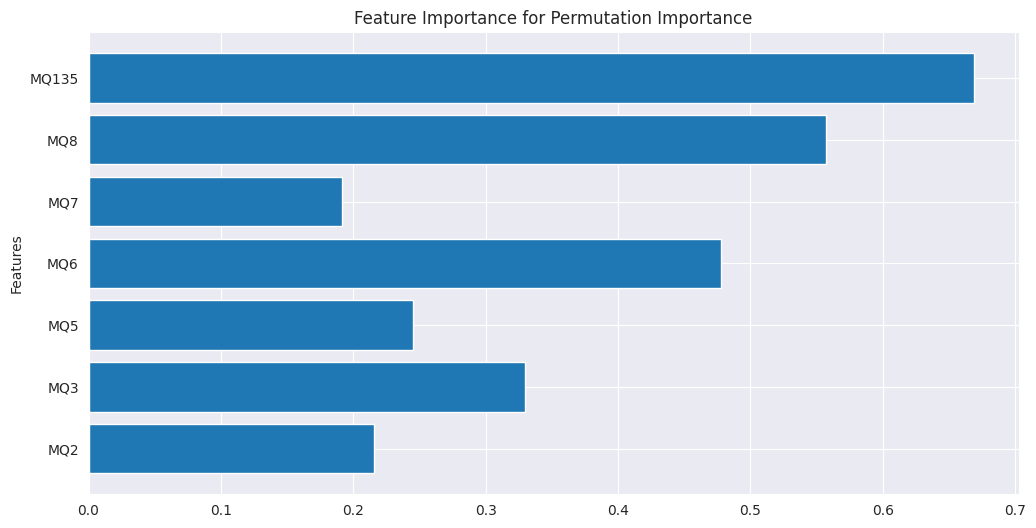

In [ ]:
def visualize_importances(feature_names, importances, title="Feature Importance for Permutation Importance", plot=True, axis_title="Features"):
    print(title)
    print (feature_names)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.barh(x_pos, importances, align='center')
        plt.yticks(x_pos, feature_names, wrap=True)
        plt.ylabel(axis_title)
        plt.title(title)
fnl = list(tab_preprocessor.column_idx.keys())
visualize_importances(fnl, attr_fic_sum.numpy())

## Bayesian

In [ ]:
import numpy as np
import torch
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from pytorch_widedeep.metrics import Accuracy
from pytorch_widedeep.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_widedeep.preprocessing import TabPreprocessor, WidePreprocessor
from pytorch_widedeep.bayesian_models import BayesianWide, BayesianTabMlp
from pytorch_widedeep.training.bayesian_trainer import BayesianTrainer

In [ ]:
tab_mlp = BayesianTabMlp(
    column_idx=tab_preprocessor.column_idx,
    # cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=continuous_cols,
    mlp_hidden_dims=[128, 64],
    prior_sigma_1=1.0,
    prior_sigma_2=0.002,
    prior_pi=0.8,
    posterior_mu_init=0,
    posterior_rho_init=-7.0,
    pred_dim=4,
)
# Pretrained Resnet 18
resnet = Vision(pretrained_model_setup="resnet18", n_trainable=4)

In [ ]:
model = WideDeep(
    BayesianTabMlp=tab_mlp,
    deepimage=resnet,
    head_hidden_dims=[256, 128],
    pred_dim=4
)

In [ ]:
trainer = Trainer(model, objective="categorical_cross_entropy",
                  optimizers=torch.optim.AdamW(model.parameters(), lr=0.01),
                  metrics=[Accuracy, Precision, F1Score])

In [ ]:
trainer.fit(
    # X_wide=X_wide,
    X_tab=X_tab,
    # X_text=X_text,
    X_img=X_images,
    target=target,
    n_epochs=5,
    batch_size=32,
    val_split=0.2,
)

valid: 100%|██████████| 40/40 [00:43<00:00,  1.08s/it, loss=0.202, metrics={'acc': 0.9297, 'prec': 0.9352, 'f1': 0.9303}]


In [ ]:
# model = BayesianWide(
#         BayesianTabMlp=tab_mlp,
#     # deeptext=basic_rnn,
#     deepimage=resnet,
#     head_hidden_dims=[256, 128],
#     input_dim=np.unique(X_tab).shape[0],
#     prior_sigma_1=1.0,
#     prior_sigma_2=0.002,
#     prior_pi=0.8,
#     posterior_mu_init=0,
#     posterior_rho_init=-7.0,
#     pred_dim =4,  # here the models are NOT passed to a WideDeep constructor class so the output dim MUST be specified
# )

In [ ]:
# trainer = BayesianTrainer(
#     model,
#     objective="multiclass",
#     optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
#     metrics=[Accuracy, Precision, F1Score],
# )

In [ ]:
# trainer.fit(
#     # X_wide=X_wide,
#     X_tab=X_tab,
#     # X_text=X_text,
#     X_img=X_images,
#     target=target,
#     n_epochs=5,
#     batch_size=32,
#     val_split=0.2,
# )